# AMPSphere v.2022-03¶

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__


### Analysis of c_AMP density in different genera

Most of our data shows that species more abundandant in these environments, tend to have more AMP genes. To address this issue, we normalized the number of c_AMP genes in these genera dividing it by the assembled base pairs per genera.

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import Phylo
from re import sub
from tqdm import tqdm
from itertools import combinations
from matplotlib.colors import to_hex
from scipy.stats import spearmanr, mannwhitneyu
from scipy.stats import percentileofscore as posr
from statsmodels.stats.multitest import multipletests

In [2]:
# load data
# getting amp genes per taxon
taxonomy_amps = pd.read_table('data/complete_amps_associated_taxonomy.tsv.gz')
taxonomy_amps = taxonomy_amps[taxonomy_amps.level.isin(['species', 'genus'])]
#taxonomy_amps['source'] = taxonomy_amps['source'].str.replace('Prevotellamassilia', 'Prevotella massilia')
taxonomy_amps['fixed'] = taxonomy_amps.source.apply(lambda x: x.split()[0])
taxonomy_amps = taxonomy_amps.groupby('fixed').agg('size')
taxonomy_amps = taxonomy_amps.sort_values()

bps = pd.read_table('data/bps-per-taxon.tsv.xz', header='infer')
bps = bps[bps.level.isin(['species', 'genus'])]
#bps['name'] = bps['name'].str.replace('Prevotellamassilia', 'Prevotella massilia')
bps['fixed'] = bps['name'].apply(lambda x: x.split(' ')[0])

In [3]:
# work dfs
taxbps = bps[['fixed', 'nbps']].groupby('fixed').agg('sum')
taxbps = pd.concat([taxonomy_amps, taxbps], axis=1).fillna(0)
taxbps = taxbps.rename({0: 'amp_genes'}, axis=1)
taxbps['amps_per_Gbp'] = taxbps['amp_genes'] * 1e9 / taxbps['nbps']

Text(0, 0.5, 'AMP genes per genus')

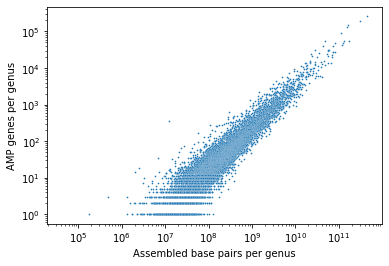

In [4]:
# plot AMP per bp per taxon
sns.scatterplot(data=taxbps, x='nbps', y='amp_genes', s=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Assembled base pairs per genus')
plt.ylabel('AMP genes per genus')

In [5]:
# get statistics
a = taxbps.loc[taxbps.amp_genes > 0, 'nbps'].mean() / 1e9
b = taxbps.loc[taxbps.amp_genes > 0, 'nbps'].std() / 1e9
c = taxbps.loc[taxbps.amp_genes == 0, 'nbps'].mean() / 1e9
d = taxbps.loc[taxbps.amp_genes == 0, 'nbps'].std() / 1e9

print(f'''Statistics for the assembly bps by taxon:

- Taxa presenting AMPs
Average: {a:.2f} Gbp
Stdev.: {b:.2f} Gbp

- Taxa not presenting AMPs
Average: {c:.2f} Gbp
Stdev.: {d:.2f} Gbp''')

Statistics for the assembly bps by taxon:

- Taxa presenting AMPs
Average: 1.12 Gbp
Stdev.: 8.10 Gbp

- Taxa not presenting AMPs
Average: 0.01 Gbp
Stdev.: 0.01 Gbp


In [6]:
# calculating quantiles for top taxa in AMPSphere
idf = taxbps[taxbps.amps_per_Gbp > 0]
idf = idf.sort_values(by='amps_per_Gbp')
idf = idf['amps_per_Gbp']

print('Percentile of AMP densities by genera:\n')
print('Bradyrhizobium', '\t', posr(idf, idf.loc['Bradyrhizobium'], kind='rank'))
print('Prevotella', '\t', posr(idf, idf.loc['Prevotella'], kind='rank'))
print('Pelagibacter', '\t', posr(idf, idf.loc['Pelagibacter'], kind='rank'))
print('Faecalibacterium', '\t', posr(idf, idf.loc['Faecalibacterium'], kind='rank'))
print('CAG-110', '\t', posr(idf, idf.loc['CAG-110'], kind='rank'))

Percentile of AMP densities by genera:

Bradyrhizobium 	 84.08706166868198
Prevotella 	 95.53808948004837
Pelagibacter 	 85.16324062877872
Faecalibacterium 	 98.25876662636034
CAG-110 	 94.03869407496977


In [7]:
# add error to normalized AMPs per Gbp
p = taxbps['amp_genes'] / taxbps['nbps']
taxbps['MOE'] = np.sqrt(p * (1 - p) / taxbps['nbps'])

# our confidence level is set to 95%
# then Z=1.96
taxbps['MOE'] = 1.96 * taxbps['MOE']  
# fix proportion to Gbp
taxbps['MOE'] = taxbps['MOE'] * 1e9

taxbps['UL'] = taxbps['amps_per_Gbp'] + taxbps['MOE']
taxbps['LL'] = taxbps['amps_per_Gbp'] - taxbps['MOE']
taxbps['VAR_pct'] = taxbps['MOE'] * 100 / taxbps['amps_per_Gbp']

Text(0.5, 0, 'AMP density (c_AMPs per Gbp)')

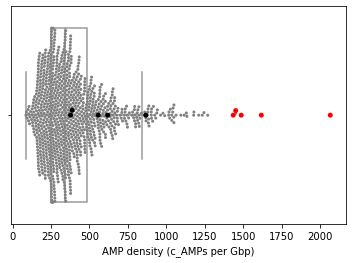

In [8]:
fdata = taxbps[taxbps.VAR_pct <= 10]

sns.boxplot(x=fdata['amps_per_Gbp'],
            showfliers=False,
            color='white')

sns.swarmplot(x=fdata['amps_per_Gbp'],
              color='gray',
              s=3)

toptaxa_ampsphere = ['Prevotella', 'Bradyrhizobium', 'Pelagibacter', 'Faecalibacterium', 'CAG-110']
toptaxa_density = ['Algorimicrobium', 'TMED78', 'SFJ001', 'STGJ01', 'CAG-462']

sns.swarmplot(x=fdata.loc[toptaxa_ampsphere,
                         'amps_per_Gbp'],
              color='black',
              s=5)

sns.swarmplot(x=fdata.loc[toptaxa_density,
                         'amps_per_Gbp'],
              color='red',
              s=5)

plt.xlabel('AMP density (c_AMPs per Gbp)')

In [9]:
def testcutoff(n, data):
    '''
    n - represents the max. percent error (0 to 100)
    '''
    ndf = data[data.VAR_pct <= n]
    a = set(ndf.sort_values(by='amps_per_Gbp').tail(10).index)
    b = set(ndf.sort_values(by='UL').tail(10).index)
    c = set(ndf.sort_values(by='LL').tail(10).index)
    p1, p2, p3 = len(a.intersection(b)) / 10, len(a.intersection(c)) / 10, len(b.intersection(c)) / 10
    print(f'''For cutoff of {n} % of margin of error, we obtained a conservation of:
    {p1} - between the AMP density and its UL
    {p2} - between the AMP density and its LL
    {p3} - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10''')
    return n, len(ndf), a, b, c, p1, p2, p3

In [10]:
# test different cutoffs by different % of margin of error
tests = []
for n in range(1, 100):
    tests.append(testcutoff(n, taxbps))

print('# uniting last results')
tests = pd.DataFrame(tests,
                     columns=['cutoff',
                              'dflen',
                              'top10_avg',
                              'top10_UL',
                              'top10_LL',
                              'c_avg_UL',
                              'c_avg_LL',
                              'c_UL_LL'])

tests

For cutoff of 1 % of margin of error, we obtained a conservation of:
    1.0 - between the AMP density and its UL
    1.0 - between the AMP density and its LL
    1.0 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 2 % of margin of error, we obtained a conservation of:
    1.0 - between the AMP density and its UL
    1.0 - between the AMP density and its LL
    1.0 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 3 % of margin of error, we obtained a conservation of:
    1.0 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.9 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 4 % of margin of error, we obtained a conservation of:
    1.0 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.9 - between the UL and its LL of the AMP de

For cutoff of 38 % of margin of error, we obtained a conservation of:
    0.9 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.8 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 39 % of margin of error, we obtained a conservation of:
    0.9 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.8 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 40 % of margin of error, we obtained a conservation of:
    0.9 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.8 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 41 % of margin of error, we obtained a conservation of:
    0.9 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.8 - between the UL and its LL of the AM

For cutoff of 84 % of margin of error, we obtained a conservation of:
    0.8 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.7 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 85 % of margin of error, we obtained a conservation of:
    0.8 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.7 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 86 % of margin of error, we obtained a conservation of:
    0.8 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.7 - between the UL and its LL of the AMP density
    ** the conservation of assessed in the top 10
For cutoff of 87 % of margin of error, we obtained a conservation of:
    0.8 - between the AMP density and its UL
    0.9 - between the AMP density and its LL
    0.7 - between the UL and its LL of the AM

,cutoff,dflen,top10_avg,top10_UL,top10_LL,c_avg_UL,c_avg_LL,c_UL_LL
0,1,13,"{Faecalibacterium, Phocaeicola, Parabacteroide...","{Faecalibacterium, Phocaeicola, Parabacteroide...","{Faecalibacterium, Phocaeicola, Parabacteroide...",1.0,1.0,1.0
1,2,51,"{Faecalibacterium, Phocaeicola, Parabacteroide...","{Faecalibacterium, Phocaeicola, Parabacteroide...","{Faecalibacterium, Phocaeicola, Parabacteroide...",1.0,1.0,1.0
2,3,118,"{Adlercreutzia, Mitsuokella, Firm-11, Evtepia,...","{Adlercreutzia, Mitsuokella, Firm-11, Evtepia,...","{Adlercreutzia, Mitsuokella, Phocaeicola, Firm...",1.0,0.9,0.9
3,4,205,"{Adlercreutzia, Mitsuokella, Eggerthella, SFMI...","{Adlercreutzia, Mitsuokella, Eggerthella, SFMI...","{Adlercreutzia, Mitsuokella, Eggerthella, Evte...",1.0,0.9,0.9
4,5,318,"{Adlercreutzia, Mitsuokella, SFJ001, CAG-1193,...","{Adlercreutzia, Mitsuokella, SFJ001, CAG-1193,...","{Adlercreutzia, Mitsuokella, SFJ001, CAG-1193,...",0.9,0.9,0.8
...,...,...,...,...,...,...,...,...
94,95,7018,"{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...","{Nanoarchaeum, 2-01-FULL-41-18-A, T1SED10-213,...","{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...",0.8,0.9,0.7
95,96,7018,"{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...","{Nanoarchaeum, 2-01-FULL-41-18-A, T1SED10-213,...","{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...",0.8,0.9,0.7
96,97,7018,"{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...","{Nanoarchaeum, 2-01-FULL-41-18-A, T1SED10-213,...","{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...",0.8,0.9,0.7
97,98,7309,"{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...","{Nanoarchaeum, 2-01-FULL-41-18-A, T1SED10-213,...","{Nanoarchaeum, 2-01-FULL-41-18-A, Andreesenia,...",0.8,0.9,0.7


### Checking taxonomy groups using AMP density

In [11]:
taxbps = taxbps.drop(['UL', 'LL'], axis=1).reset_index()
taxbps.rename({'fixed': 'genus'}, axis=1, inplace=True)

In [12]:
# prepare data
tax = pd.read_table("data/bac120_taxonomy_r207.tsv.xz",
                    sep='\t',
                    names=['domain', 'phylum',
                           'class', 'order',
                           'family', 'genus',
                           'species'])

tax_one = tax.copy()
tax_one.drop('species', axis=1, inplace=True)
tax_one = tax_one.drop_duplicates()
tax_one['genus'] = [x[3:] for x in tax_one.genus]

tax_one = tax_one.reset_index(drop=True)
tax_one = tax_one.drop_duplicates()

In [13]:
taxbps = taxbps.merge(on='genus', right=tax_one)

# only phyla with 100 genera or more
k = taxbps.groupby('phylum').agg('size').sort_values()
k = k[k >= 100].index

fdata = taxbps[taxbps.phylum.isin(k)]
fdata = fdata.sort_values(by='phylum')

fdata = fdata[['phylum', 'genus',
               'amp_genes', 'nbps',
               'amps_per_Gbp', 'MOE',
               'VAR_pct']]

In [14]:
# select just genera with a maximum error of 10%
fdata = fdata[fdata.VAR_pct <= 10]
fdata

,phylum,genus,amp_genes,nbps,amps_per_Gbp,MOE,VAR_pct
6982,p__Acidobacteriota,Edaphobacter,2288.0,10539953147,217.078764,8.894988,4.097585
6823,p__Acidobacteriota,UBA7540,1206.0,3792966097,317.956968,17.945299,5.643939
6816,p__Acidobacteriota,2-12-FULL-66-21,1171.0,5214663174,224.559087,12.861991,5.727665
6557,p__Acidobacteriota,PSRF01,594.0,5857902959,101.401475,8.154683,8.041977
6560,p__Acidobacteriota,QHXN01,597.0,2852863681,209.263416,16.786578,8.021745
...,...,...,...,...,...,...,...
6553,p__Verrucomicrobiota,Lacunisphaera,592.0,1951235316,303.397543,24.440338,8.055549
6840,p__Verrucomicrobiota,SW10,1283.0,3118421073,411.426158,22.513061,5.471957
6457,p__Verrucomicrobiota,Roseibacillus,471.0,2299564112,204.821426,18.497837,9.031202
6882,p__Verrucomicrobiota,Victivallis,1480.0,3521981537,420.217989,21.409167,5.094776


In [15]:
# eliminate outliers using Tukey fences
q1, q3 = fdata.amps_per_Gbp.quantile([0.25, 0.75])
iqr = q3 - q1
ul, ll = q3 + (1.5*iqr), q1 - (1.5*iqr)
fdata = fdata[(fdata.amps_per_Gbp >= ll) & (fdata.amps_per_Gbp <= ul)]

In [16]:
# determine order of phyla by their Q50
porder = fdata.groupby('phylum')['amps_per_Gbp'].quantile(0.5)
porder = porder.sort_values()
print(porder)

porder = porder.index

phylum
p__Planctomycetota      204.962991
p__Acidobacteriota      228.667584
p__Chloroflexota        263.098695
p__Cyanobacteria        268.690168
p__Desulfobacterota     269.979473
p__Patescibacteria      281.967419
p__Verrucomicrobiota    289.116904
p__Bacteroidota         306.189408
p__Actinobacteriota     328.324792
p__Proteobacteria       339.359324
p__Firmicutes           379.297985
p__Firmicutes_A         413.157309
Name: amps_per_Gbp, dtype: float64


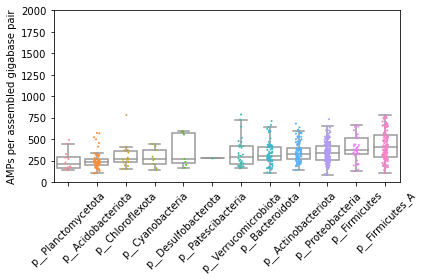

In [17]:
fig, ax = plt.subplots()

sns.boxplot(ax=ax,
            data=fdata,
            x='phylum',
            y='amps_per_Gbp',
            showfliers=False,
            color='white',
            order=porder)

sns.stripplot(ax=ax,
              data=fdata,
              x='phylum',
              y='amps_per_Gbp',
              s=2,
              order=porder)

ax.set_ylim(0, 2000)
ax.set_xticklabels(porder, rotation=45)
ax.set_xlabel('')
ax.set_ylabel('AMPs per assembled gigabase pair')
plt.tight_layout()

In [18]:
test = []
for i, j in combinations(porder, 2):
    u, p = mannwhitneyu(fdata[fdata.phylum == i]['amps_per_Gbp'],
                        fdata[fdata.phylum == j]['amps_per_Gbp'])
    test.append((i, j, u, p))

test = pd.DataFrame(test,
                    columns=['tax1', 'tax2',
                             'u_stat', 'p-value'])

_, test['p-value'], _, _ = multipletests(test['p-value'],
                                         method='bonferroni',
                                         is_sorted=False,
                                         returnsorted=False)

test = test[test['p-value'] < 5e-2]
test

,tax1,tax2,u_stat,p-value
10,p__Planctomycetota,p__Firmicutes_A,278.0,2.182980e-02
16,p__Acidobacteriota,p__Bacteroidota,1428.0,2.295301e-03
17,p__Acidobacteriota,p__Actinobacteriota,1404.0,4.356972e-07
18,p__Acidobacteriota,p__Proteobacteria,2744.0,2.363499e-08
19,p__Acidobacteriota,p__Firmicutes,441.0,6.548473e-05
20,p__Acidobacteriota,p__Firmicutes_A,1355.0,3.067119e-10
59,p__Bacteroidota,p__Firmicutes_A,3415.0,3.298929e-03
62,p__Actinobacteriota,p__Firmicutes_A,4836.0,3.928120e-02
64,p__Proteobacteria,p__Firmicutes_A,9151.0,2.475119e-03


### Analysis of c_AMP density regarding taxonomy distribution in the tree of life

In [19]:
# load lineages from GTDB
gtdb_tree = Phylo.read('data/bac120_r202.tre', 'newick')
taxaintree = [i.name for i in gtdb_tree.get_terminals()]

tax = pd.read_table("data/bac120_taxonomy_r207.tsv.xz",
                    sep='\t',
                    names=['domain', 'phylum',
                           'class', 'order',
                           'family', 'genus',
                           'species'])

# get common genomes from tree and lineage
taxaintree = set(tax.index).intersection(set(taxaintree))
tax = tax.loc[taxaintree, 'genus']
tax = tax.reset_index()
tax.rename({'index': 'genome'}, axis=1, inplace=True)

/tmp/ipykernel_1642711/3220117425.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tax = tax.loc[taxaintree, 'genus']


In [20]:
# only phyla with 100 genera or more
k = taxbps.groupby('phylum').agg('size').sort_values()
k = k[k >= 100].index

fdata = taxbps[taxbps.phylum.isin(k)]
fdata = fdata.sort_values(by='phylum')

# only taxa with maximum 10% of error
fdata = fdata[fdata.VAR_pct <= 10]

# merge data
tax.genus = [x[3:] for x in tax.genus]
tax = tax.merge(on='genus', right=fdata)
tax

,genome,genus,amp_genes,nbps,amps_per_Gbp,MOE,VAR_pct,domain,phylum,class,order,family
0,GB_GCA_000434975.1,Prevotella,188688.0,305272291111,618.097369,2.788950,0.451215,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae
1,GB_GCA_002479145.1,Prevotella,188688.0,305272291111,618.097369,2.788950,0.451215,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae
2,RS_GCF_000619825.1,Prevotella,188688.0,305272291111,618.097369,2.788950,0.451215,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae
3,GB_GCA_002372575.1,Prevotella,188688.0,305272291111,618.097369,2.788950,0.451215,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae
4,GB_GCA_002353825.1,Prevotella,188688.0,305272291111,618.097369,2.788950,0.451215,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae
...,...,...,...,...,...,...,...,...,...,...,...,...
7762,RS_GCF_900175965.1,Rubrobacter,903.0,3468171366,260.367757,16.982411,6.522471,d__Bacteria,p__Actinobacteriota,c__Rubrobacteria,o__Rubrobacterales,f__Rubrobacteraceae
7763,RS_GCF_000025185.1,Pirellula,482.0,3518256818,136.999663,12.230720,8.927555,d__Bacteria,p__Planctomycetota,c__Planctomycetia,o__Pirellulales,f__Pirellulaceae
7764,GB_GCA_003170295.1,Palsa-187,789.0,4007540567,196.878855,13.737781,6.977784,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Bryobacterales,f__Bryobacteraceae
7765,RS_GCF_000482845.1,Anaerobiospirillum,1103.0,1378929712,799.895738,47.206470,5.901578,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Succinivibrionaceae


In [21]:
# keep only 1 genome per taxon
ndata = tax.groupby('genus').apply(lambda x: x.head(1))
ndata = ndata.reset_index(drop=True)

# create a hash table for genomes and genera 
taxkeys = ndata[['genome', 'genus']]
taxkeys = taxkeys.set_index('genome')
taxkeys = taxkeys.to_dict()['genus']

# eliminate genomes without AMP density
# or redundant
for i in tqdm(gtdb_tree.get_terminals()):
    if i.name in taxkeys: i.name = taxkeys[i.name]
    else: gtdb_tree.prune(i)

# excluding discrepant value (5 times the second most abundant)
# gtdb_tree.prune('Shimwellia')

# export tree file for iTOL
# Phylo.write(gtdb_tree, 'out.tre', 'newick')

100%|███████████████████████████████████| 23458/23458 [00:15<00:00, 1525.75it/s]


In [22]:
# reduce tree
# tree is too big with many small phylum
# reducing tree
k = ndata.groupby('phylum').agg('size')
k = k[k >= 15].index
ndata = ndata[ndata.phylum.isin(k)]
ksp=set(ndata.genus)

# edit tree 
for i in tqdm(gtdb_tree.get_terminals()):
    if i.name not in ksp: gtdb_tree.prune(i.name)

#Phylo.write(gtdb_tree, 'red_out.tre', 'newick')

100%|██████████████████████████████████████| 665/665 [00:00<00:00, 13699.47it/s]


In [23]:
# export annotation of phylum
cmap = plt.cm.get_cmap('tab20')

phylum = dict()
for idx, i in enumerate(set(ndata.phylum)):
    phylum[i] = to_hex(cmap(idx))

# {'Acidobacteriota': '#1f77b4', 'Actinobacteriota': '#aec7e8', 'Bacteroidota': '#ff7f0e', 'Firmicutes': '#ffbb78', 'Firmicutes_A': '#2ca02c', 'Proteobacteria': '#98df8a', 'Verrucomicrobiota': '#d62728'}

ndata['color'] = ndata.phylum.apply(lambda x: phylum[x])

ndata[['phylum', 'color']].sort_values(by='phylum').drop_duplicates()

# annotation for color strip in iTOL
# ndata[['genus', 'color', 'phylum']].to_csv('out.anno_ph.txt', sep='\t', header=None, index=None)

,phylum,color
1,p__Acidobacteriota,#aec7e8
297,p__Actinobacteriota,#2ca02c
47,p__Bacteroidota,#d62728
604,p__Firmicutes,#ffbb78
584,p__Firmicutes_A,#1f77b4
527,p__Proteobacteria,#98df8a
511,p__Verrucomicrobiota,#ff7f0e


In [24]:
# annotation of AMP density
q2 = ndata['amps_per_Gbp'].quantile(0.5)
print(f'Standard line representing Q50: y={q2}')

ndata[['genus', 'amps_per_Gbp']]

Standard line representing Q50: y=339.052465484754


,genus,amps_per_Gbp
1,12-FULL-67-14b,219.688616
2,13-2-20CM-66-19,295.371622
3,13-2-20CM-68-14,520.983944
4,14-2,433.645906
5,2-02-FULL-65-29,228.589419
...,...,...
658,Vitreoscilla,502.004666
660,Winogradskyella,341.638472
661,Xanthomonas,580.276713
662,Z2-YC6860,321.335891


The resulting reduced tree was produced using [iTOL](https://itol.embl.de/)
and the annotation files for AMP density and phylum.

Resulting tree is in: docs/xM-1rj4CIUbe-fe33NNI-w.svg

![tree](docs/xM-1rj4CIUbe-fe33NNI-w.svg)

To reproduce the three above, you will need the files below:

In [25]:
Phylo.write(gtdb_tree, 'red_out.tre', 'newick')
ndata[['genus', 'color', 'phylum']].to_csv('out.anno_ph.txt', sep='\t', header=None, index=None)
ndata[['genus', 'amps_per_Gbp', 'MOE']].to_csv('out.anno.txt', sep='\t', header=None, index=None)